# Parameter Definition

This section defines all physical and numerical parameters for the geothermal doublet benchmark simulation. The parameters include simulation time, well configuration (distance and flow rate), rock properties (porosity, density, heat capacity, thermal conductivity), and fluid properties. Additional parameters control the numerical model setup, including domain size, mesh resolution, and the vertical structure near aquitards. These values form the basis for the coupled flow and heat transport simulation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Simulation period
tmax = 50           # For the analytical solution (a)

# Well setup
a = 450             # Half the distance between the wells (m)
Q = 0.03            # Injection rate (m³/s)

# Rock
M = 30              # Vertical extent of the aquifer (m)
phi = 0.4           # Porosity (-) 
rho_S = 1900        # Density (kg/m³)
c_S = 850           # Specific heat capacity (J/(kg*K))
lambda_S = 3.0      # Thermal conductivity (W/(m*K))

# Fluid
rho_F = 1100        # Density (kg/m³)
c_F = 4200          # Specific heat capacity (J/(kg*K))

# Numerical model
diameter = 4000     # Diameter of the domain (m)
dwell = 0.3         # Diameter of the wells (m)
Tin = 1.0           # Injection temperature (A.U.)
Tref = 0.0          # Reference temperature = normalized initial reservoir temperature (A.U.)
lc = diameter / 10  # Reference mesh size for gmsh mesh generator

dM = 1             # Vertical distance between well and aquitard (m)
L0 = 0.01          # Vertical element size in the aquitard
                    # at the interface between aquifer and aquitard (m)

seconds_per_year = 60*60*24*365     # Conversion factor 

## System Characterization

This cell calculates key characteristic parameters for the geothermal doublet system. The thermal breakthrough time at the extraction well is computed based on the volumetric heat capacity ratio and flow geometry. Additionally, the thermal diffusion length is estimated to determine the affected zone thickness within the aquitard layer. These calculations help assess the system's thermal performance and spatial extent of thermal influence.

In [2]:
## Characterization of the system
# Thermal breakthrough at extraction well 
rho_A_c_A = phi * rho_F * c_F + (1 - phi) * rho_S * c_S
G = rho_A_c_A / (rho_F * c_F)
tb = G * 4 * np.pi * M * a * a / (3 * Q) / seconds_per_year
print(f"The thermal breaktrough at the extraction well is {tb:.2f} years.")

# Affected thickness of the aquitard from (thermal) diffusion length
L = np.sqrt(2 * tmax * seconds_per_year * lambda_S / rho_A_c_A)
print(f"The affected zone within the aquitard spans {L:.2f} meters in thickness.")

The thermal breaktrough at the extraction well is 16.40 years.
The affected zone within the aquitard spans 57.95 meters in thickness.


## Mesh Size Function Definition

This section installs the required mesh generation libraries (gmsh and pygmsh) and defines a custom mesh size function for the doublet configuration. The mesh size function creates finer mesh resolution near the injection and extraction wells, where gradients are expected to be steeper. The function is visualized using a logarithmic color scale to show the spatial distribution of expected element sizes across the domain.

Looking in indexes: https://gmsh.info/python-packages-dev-nox


ERROR: Could not find a version that satisfies the requirement gmsh (from versions: none)
ERROR: No matching distribution found for gmsh


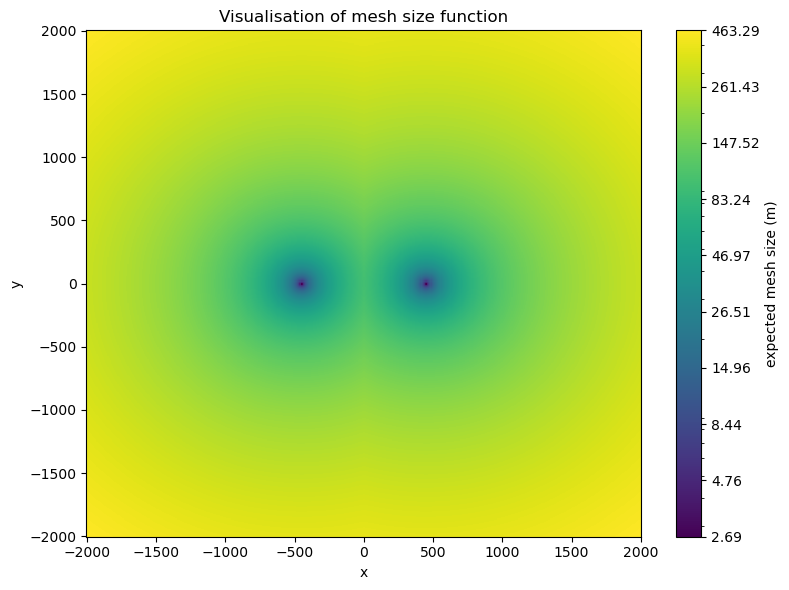

In [3]:
#Install gmsh without X11 dependency
!pip install -i https://gmsh.info/python-packages-dev-nox --force-reinstall --no-cache-dir gmsh
!pip install pygmsh

import pygmsh
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

def field(x, y, d):
    return 0.4*np.power(np.sqrt((x+d)*(x+d) + y*y), 0.9)+1.0

def doublet(x, y, d):
    return np.minimum(field(x, y, -d), field(x, y, d))

# Evaluate mesh size function
X, Y = np.meshgrid(np.linspace(-diameter/2, diameter/2, 500), 
                   np.linspace(-diameter/2, diameter/2, 500))
Z = doublet(X, Y, d=a)
z_min = np.min(Z)
z_max = np.max(Z)

# Plot with logarithmic color scale
plt.figure(figsize=(8, 6))
plt.pcolormesh(X, Y, Z, shading='auto', norm=LogNorm(vmin=z_min, vmax=z_max), cmap='viridis')
cbar = plt.colorbar(label='expected mesh size (m)')
plt.title('Visualisation of mesh size function')
plt.xlabel('x')
plt.ylabel('y')
plt.tight_layout()

ticks = np.geomspace(z_min, z_max, 10)  # Example: min, middle, max
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{tick:.2f}" for tick in ticks])


plt.show()

## 2D Mesh Generation

This cell generates the two-dimensional base geometry for the geothermal doublet using pygmsh. A circular disk represents the aquifer domain, with two point features marking the injection and extraction well locations. The mesh is refined near the wells using the previously defined mesh size callback function. The resulting triangular mesh is visualized and saved as a VTU file for further processing.

c:\Users\jante\Anaconda3\envs\python_3.11\Lib\site-packages\pygmsh\occ\geometry.py:253: UserWarning: Specified mesh size for <pygmsh Disk object, ID 1> discarded in Boolean fragments operation.
  warnings.warn(


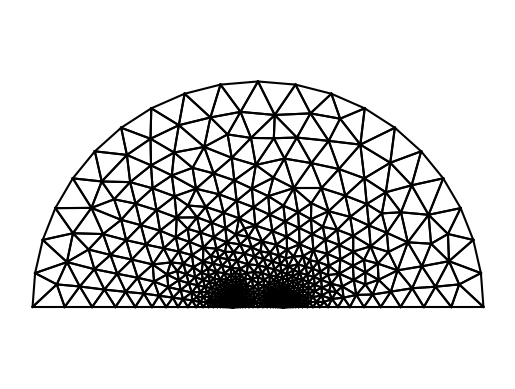

In [4]:
with pygmsh.occ.Geometry() as geom:

    #Disk as base geometry
    disk = geom.add_disk([0.0, 0.0], diameter, mesh_size=lc)

    #Add injection and extraction well as points in the geometry
    for b in [-a, a]:
        p = geom.add_point([b, 0, 0], mesh_size=0.1)
        geom.boolean_fragments([disk], [p], delete_other=False)

    #
    rectangle = [geom.add_rectangle([-diameter, -diameter, 0.0], 2*diameter, diameter)]
    geom.boolean_difference(disk, rectangle)

    geom.set_mesh_size_callback(
        lambda dim, tag, x, y, z, lc: doublet(x,y,a)
    )

    mesh = geom.generate_mesh()

triangles = mesh.cells_dict["triangle"]
points = mesh.points

pts = points[:, :2]
for e in triangles:
    for idx in [[0, 1], [1, 2], [2, 0]]:
        X = pts[e[idx]]
        plt.plot(X[:, 0], X[:, 1], "-k")

plt.gca().set_aspect("equal", "datalim")
plt.axis("off")
plt.show()

mesh.write("domain.vtu")

## 3D Mesh Extrusion and Material Properties

This section extrudes the 2D mesh into a 3D layered structure representing the aquifer and optional aquitard layers depending on the scenario. Material properties (porosity and permeability) are assigned to each layer according to the scenario configuration. The mesh is equipped with bulk node and element IDs required by OpenGeoSys. Finally, the 3D mesh with material properties is visualized and saved for the simulation.

In [ ]:
import pyvista as pv
from geo import layersfromsurf

scenario = 1


if scenario == 1:
    nAquifer = 1

elif scenario == 2:
    nAquifer = 3
    nAquitard = 5

    phiAquitard = 0.1
    KAquitard = 1e-14

KAquifer = 1e-10


for file in ["domain.vtu"]:

    mesh2d = pv.read(file)

    if scenario == 1:
        thickness = np.array([M])

    elif scenario == 2:
        pAquitard = np.geomspace(L0, L, nAquitard+2)
        dAquitard = np.diff(pAquitard)
        thickness = np.hstack((np.flip(dAquitard), 
                            np.array([dM]),
                            np.array([(M-dM)/2/nAquifer] * nAquifer)))

    mesh3d = layersfromsurf(mesh2d, thickness)

    mesh3d["porosity"] = np.repeat(phi, mesh3d.number_of_cells)
    mesh3d["permeability"] = np.repeat(KAquifer, mesh3d.number_of_cells)

    if scenario == 2:
        mesh3d["porosity"][mesh3d["Layer"] <= nAquitard] = phiAquitard
        mesh3d["permeability"][mesh3d["Layer"] <= nAquitard] = KAquifer 

    #mesh3d["Porosity"][mesh3d["Layer"] > (nAquitard+nAquifer)] = phiAquitard
    #mesh3d["Permeability"][mesh3d["Layer"] > (nAquitard+nAquifer)] = KAquitard

    # Add info for OGS
    mesh3d.point_data["bulk_node_ids"] = np.arange(0, mesh3d.n_points, dtype=np.uint64)
    mesh3d.cell_data["bulk_element_ids"] = np.arange(0, mesh3d.n_cells, dtype=np.uint64)

    mesh3d.save(file)


#mesh3d.plot(scalars="Layer", show_edges=True, cmap="viridis")
mesh3d.plot(scalars="porosity", show_edges=True, cmap="Pastel1")

Widget(value='<iframe src="http://localhost:63099/index.html?ui=P_0x1dc5553bf90_0&reconnect=auto" class="pyvis…

INFO: 127.0.0.1 [14/Jan/2026:13:35:40 +0100] "GET /index.html?ui=P_0x1dc5705bcd0_1&reconnect=auto HTTP/1.1" 200 237 "-" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.107.1 Chrome/142.0.7444.175 Electron/39.2.3 Safari/537.36"
INFO: 127.0.0.1 [14/Jan/2026:13:35:40 +0100] "GET /assets/index-e80c1ba5.css HTTP/1.1" 200 236 "http://localhost:63099/index.html?ui=P_0x1dc5553bf90_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.107.1 Chrome/142.0.7444.175 Electron/39.2.3 Safari/537.36"
INFO: 127.0.0.1 [14/Jan/2026:13:35:40 +0100] "GET /assets/index-5f6ebc8d.js HTTP/1.1" 200 254 "http://localhost:63099/index.html?ui=P_0x1dc5553bf90_0&reconnect=auto" "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Code/1.107.1 Chrome/142.0.7444.175 Electron/39.2.3 Safari/537.36"
ERROR: Unhandled exception
Traceback (most recent call last):
  File "c:\Users\jante\Anaconda3\envs\pyt

## Boundary Extraction

This cell extracts different boundary surfaces from the 3D mesh based on surface normal directions. Surfaces with normals pointing downward, upward, and horizontally are identified as bottom, top, and profile boundaries respectively. All remaining surface cells are grouped as the general boundary. Each extracted surface is saved as a separate VTU file for boundary condition application in the simulation.

In [6]:
surf = mesh3d.extract_surface()
cell_normals = surf.cell_normals

n_vectors = [[0, 0, -1],[0,0,1],[0,1,0]]
surf_names = ["bottom", "top", "profile"]
unsurf_name = "boundary"
eps = 1e-8

all_selected = np.array([])

for n1, name in zip(n_vectors, surf_names):

    # Calculate L2-Norm (i.e., the Euclidean norm)
    l2_norms = np.linalg.norm(cell_normals - n1, axis=1)  # shape: (n,)
    selected_cells = np.where(l2_norms < eps)[0]  # e.g., almost perpendicular upward
    subset = surf.extract_cells(selected_cells)
    subset.save(name + ".vtu")

    all_selected = np.concatenate((all_selected, selected_cells))

# Unselected cells
unselected_cells = np.setdiff1d(np.arange(surf.n_cells), all_selected)

un_subset = surf.extract_cells(unselected_cells)
un_subset.save(unsurf_name + ".vtu")

un_subset.plot()

C:\Users\jante\AppData\Local\Temp\ipykernel_16912\387592233.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  l2_norms = np.linalg.norm(cell_normals - n1, axis=1)  # shape: (n,)


Widget(value='<iframe src="http://localhost:63099/index.html?ui=P_0x1dc5705bcd0_1&reconnect=auto" class="pyvis…

## Well Geometry Definition

This section extracts the injection and extraction well geometries from the profile boundary surface. Points along vertical line segments at the well locations are identified and connected to create 1D line elements representing each well. The scenario determines the vertical extent of the wells within the aquifer or including aquitard layers. The extracted well geometries are visualized and saved as separate VTU files for source/sink term application.

In [7]:
import pyvista as pv
import numpy as np
from helper import find_nearby_points

# Input file and target points
input_vtu = r"profile.vtu"  # Path to the existing VTU file
output_vtu = [r"injection.vtu", r"extraction.vtu"]  # Paths to the new VTU files

if scenario == 1:
    # Two known points (e.g., start and end of the line)
    points = np.array([[[a, 0, -1000], [a, 0, 1000]], # Injection well
            [[-a, 0, -1000], [-a, 0, 1000]]]) # Extraction well

elif scenario == 2:
    # Two known points (e.g., start and end of the line)
    points = np.array([[[a, 0, L-L0+dM], [a, 0, L+M]], # Injection well
            [[-a, 0, L-L0+dM], [-a, 0, L+M]]]) # Extraction well

# Load VTU file
mesh = pv.read(input_vtu)

for p, out_vtu in zip(points, output_vtu):

    # Extract points along the line segment
    ids = find_nearby_points(mesh, p[0], p[1])

    # Create new point cloud
    extrahierte_punkte = mesh.points[ids]

    # Build line as UnstructuredGrid
    n = len(extrahierte_punkte) - 1
    cells = []
    cell_types = []

    for i in range(n):
        cells.extend([2, i, i+1])  # Each line consists of 2 points
        cell_types.append(pv.CellType.LINE)

    # Create UnstructuredGrid
    linie_mesh = pv.UnstructuredGrid(np.array(cells), cell_types, extrahierte_punkte)

    # Save as VTU
    linie_mesh.save(out_vtu)
    print(f"Line saved as: {out_vtu}")


# Create plotter
plotter = pv.Plotter()
plotter.add_mesh(linie_mesh, color="red", line_width=4)
plotter.add_points(linie_mesh.points, color="blue", point_size=15, render_points_as_spheres=True)
plotter.show_axes()
plotter.show()


Line saved as: injection.vtu
Line saved as: extraction.vtu


Widget(value='<iframe src="http://localhost:63099/index.html?ui=P_0x1dc54ef1dd0_2&reconnect=auto" class="pyvis…

## Source Terms at injection well

The injection rate is constant. 

The heat flow rate ($\dot{Q}$) is calculated using the following formula: 

$$\dot{Q} = \dot{V} \cdot \rho \cdot C_{p} \cdot (T_{in} - T(x))$$

## Injection Well Configuration

This cell calculates the volumetric and thermal injection rates for the source term at the injection well. The volumetric rate is normalized by the aquifer thickness and distributed over half the well length. The thermal injection rate accounts for fluid density, specific heat capacity, and the temperature difference between injected fluid and reservoir. These parameters are written to the OpenGeoSys project file to define the injection boundary conditions.

In [8]:
import ogstools as ogs

# Calculate inflow rates at injection well
qVin = Q / M / 2                  # Pressure
qTin = rho_F * c_F * qVin * (Tin - Tref)    # Temperature

# Define injection rate for source term at injection well (pressure)
prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.replace_parameter_value(name="injection_rate", value=qVin)
prj.replace_parameter_value(name="heatinjection", value=qTin)
prj.write_input() 

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

## Robin Boundary Condition for Heat Extraction

For the extraction well, we want to implement a heat sink term with a temperature dependent heat flow rate. However, OpenGeoSys does not directly support this via Python source terms for heat extraction because Python terms are integrated explicitly into the numerical system of equations. This causes numerical instability when extracting heat from the system, as the explicit treatment can lead to negative temperatures or convergence issues.

The Robin boundary condition provides an equivalent but numerically stable alternative that is integrated implicitly into the system matrix.

### Formula for Heat Flow Rate 

The heat flow rate ($\dot{Q}$) is calculated using the following formula: 

$$\dot{Q} = \dot{V} \cdot \rho \cdot C_{p} \cdot (T_0 - T(x))$$

**Where:**
- $\dot{Q}$ = Heat flow rate (Power, e.g., Watts [W] or $\text{J/s}$)
- $\dot{V}$ = Volume flow rate (e.g., $\text{m}^{3}/\text{s}$)
- $\rho$ = Fluid density (e.g., $\text{kg/m}^{3}$)
- $C_{p}$ = Specific heat capacity (e.g., $\text{J/kg} \cdot \text{K}$ or $\text{J/kg} \cdot ^{\circ}\text{C}$)
- $T_0$ = Reference temperature, here initial reservoir temperature (e.g., K or °C)
- $T(x)$ = Local temperature (e.g., K or °C)
  
### Equivalence of Robin Boundary Condition

In OpenGeoSys the Robin boundary condition is defined as:

$$\lambda\cdot\frac{\partial T}{\partial n} = \alpha (T_0 - T(x)) \quad \text{on }\Gamma_R$$

with the parameter:

$$\alpha = \dot{V} \cdot \rho \cdot C_{p}$$

**Derivation of equivalence:**

1. The left side $\lambda \cdot \frac{\partial T}{\partial n}$ represents the heat flux density (heat flow per unit area)

2. Integrating over the extraction surface area $A$:
   $$\dot{Q} = \int_A \lambda \cdot \frac{\partial T}{\partial n} \, dA = \int_A \alpha (T_0 - T(x)) \, dA$$

3. If the temperature difference $(T_0 - T(x)) \approx \Delta T$ is approximately constant over the extraction area:
   $$\dot{Q} = \alpha \cdot A \cdot \Delta T = \dot{V} \cdot \rho \cdot C_{p} \cdot \Delta T$$

This is exactly the heat flow rate formula! The Robin boundary condition automatically adapts the heat flux based on the local temperature difference, making it physically equivalent to the desired heat flow rate boundary condition and
numerically stable for heat extraction due to implicit treatment.

### Configuration in the PRJ file

```xml
<boundary_condition>
    <mesh>extraction</mesh>
    <type>Robin</type>
    <alpha>heatextraction</alpha>
    <u_0>temperature_bc</u_0>
    <area_parameter>one</area_parameter>
</boundary_condition>
```

alpha ist defined by $\alpha$. u_0 is the reference temperature and here the initial reservoir temperature $T_0$. The area_parameter is fixed to 1.0.

## Extraction Well Configuration

This cell configures the extraction well parameters for both pressure and temperature fields. The volumetric extraction rate is set equal and opposite to the injection rate. For heat extraction, the alpha parameter for the Robin boundary condition is calculated as the product of volumetric rate, fluid density, and specific heat capacity. These parameters are written to the project file to implement the numerically stable implicit heat extraction scheme.

In [ ]:
mesh2d = pv.read("extraction.vtu")

# Calculate outflow rates at extraction well
qVout = - qVin # - Q / M / 2 
alpha = qVout * rho_F * c_F
temperature_bc = Tref

# Define extraction_rate for sink term (pressure) at extraction well
prj_file = r"doublet.prj"
prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.replace_parameter_value(name="extraction_rate", value=qVout)
prj.replace_parameter_value(name="heatextraction", value=alpha)
prj.replace_parameter_value(name="temperature_bc", value=Tref)
prj.write_input()

NameError: name 'pv' is not defined

## Mesh Finalization and Quality Check

This section identifies subdomain node IDs for the boundary condition meshes within the bulk domain mesh using OGSTools utilities. The domain mesh node ordering is corrected to match the specific node sequence expected by OpenGeoSys for proper element processing. All meshes are then checked for geometric validity and consistency. These preprocessing steps ensure that the mesh files are properly configured for the OpenGeoSys simulation and help identify potential mesh quality issues before running the computationally expensive simulation.

In [ ]:
# Add bulk_node_ids with OGSTools

!identifySubdomains -m domain.vtu -- injection.vtu
!identifySubdomains -m domain.vtu -- extraction.vtu
!identifySubdomains -m domain.vtu -- boundary.vtu
# !identifySubdomains -m domain.vtu -- top.vtu
# !identifySubdomains -m domain.vtu -- bottom.vtu
# !identifySubdomains -m domain.vtu -- profile.vtu

# Check and repair meshes
!NodeReordering -i domain.vtu -o domain.vtu
!checkMesh -v domain.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v injection.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v extraction.vtu
print("-------------------------------------------------------------------------------")
!checkMesh -v boundary.vtu

Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "identifySubdomains" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "NodeReordering" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


-------------------------------------------------------------------------------


Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


-------------------------------------------------------------------------------


Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


-------------------------------------------------------------------------------


Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.
Der Befehl "checkMesh" ist entweder falsch geschrieben oder
konnte nicht gefunden werden.


## Simulation Execution

This cell loads the OpenGeoSys project file and executes the coupled flow and heat transport simulation. The simulation solves the governing partial differential equations for pressure and temperature fields in the geothermal doublet system over the specified time period. Results are written to output files for subsequent post-processing and visualization.

In [ ]:
import ogstools as ogs

prj_file = r"doublet.prj"

prj = ogs.Project(input_file=prj_file, output_file=prj_file)
prj.run_model()

Simulation: doublet.prj
Status: terminated with error code 1.
Last 10 line of the log:
info: MeshElementParameter: permeability
info: MeshElementParameter: porosity
info: ConstantParameter: pressure_ic
info: ConstantParameter: temperature_ic
info: ConstantParameter: pressure_bc
info: ConstantParameter: temperature_bc
info: ConstantParameter: injection_rate
critical: C:/Users/gitlab/code/ogs/ogs/BaseLib/ConfigTree.cpp:245 BaseLib::ConfigTree::onerror() 
error: ConfigTree: In file `doublet.prj' at path <parameters/parameter>: Value for key <value> `inf' not convertible to a vector of the desired type. Could not convert token no. 1.
error: OGS terminated with error on 2025-12-15 18:18:51+0100.



RuntimeError: OGS execution was not successful.

## Results Visualization and Comparison

This section plots the temperature breakthrough curve at the extraction well and compares numerical results with analytical solutions. The analytical solutions from Charbeneau for both solute transport and adapted heat transfer are displayed alongside the thermal breakthrough time. The numerical temperature evolution from the simulation is extracted and plotted to validate the model against analytical solution. 

In [ ]:
from helper import mean_over_time

# plot analytical solutions
F = np.linspace(1e-20, 1, 1000)
G = (phi * rho_F * c_F + (1 - phi) * rho_S * c_S) / (rho_F * c_F)
tf = 4 *np.pi * phi * M * a * a / Q * (1 - np.pi * F / np.tan(np.pi * F)) / (np.sin(np.pi * F) ** 2) / seconds_per_year
tau = G*tf/phi

print("Note: the solution for heat transfer does not consider heat exchange with the aquitard.")

plt.plot(tf, F, '--', label="solute transport, Charbeneau")
plt.plot(tau, F, '--', label="heat transfer, Charbeneau, adapted")
plt.plot([tb, tb], [0, 1], '--', label="thermal breakthrough")

# plot numerical solutions
time, temperature = mean_over_time("geothermal_doublet.pvd", "domain.vtu", "extraction.vtu", "temperature")
plt.plot(time/seconds_per_year, temperature, label="HT model")

plt.xlabel("time (a)")
plt.ylabel("temperature (-)")
plt.grid()
plt.xlim((0, tmax))
plt.legend()
plt.show()